In [1]:
# добавить из уроков
import torch
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# !pip install imblearn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    t = precision_recall_fscore_support(y_train_true, y_train_pred, average='binary')
    te = precision_recall_fscore_support(y_test_true, y_test_pred, average='binary')
    print(t)
    print(te)
    print('TRAIN f1 1')
    print(f1_score(y_train_true, y_train_pred, average='binary'))
    print('TEST f1 1')
    print(f1_score(y_test_true, y_test_pred, average='binary'))

### Обобщение работы с новой задачей 
1. Получить базовое решение
    * Минимально познакомиться с данными
    * Заполнить пропуски простым методом (нулями, медиана, среднее, мода...)
    * Обучить простую модель (линейная, деревья...)
    * Посчитать метрику качества
2. EDA
    * Изучить целевую переменную 
        * регрессия - распределение, меры центральной тенденции
        * классификация - баланс классов
    * Изучить признаки
        * корреляция
        * найти проблемные признаки
        * найти пропуски
        * найти выбросы
        * сгенерировать идеи по их заполнению
    * Изучить влияние признаков на целевую переменную
        * корреляция
        * классификация - разделение значений в зависимости от классов
    * Постоянно придумывать идеи для новых признаков (где-то их фиксировать)
3. Предобработка данных**
    * Разделить данные на train и test
    * Зависит от выбранной модели
        * Масштабирование
    * Заполнить пропуски
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Обработать выбросы
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Генерация новых признаков
        1. Категориальные признаки
            a. pd.get_dummies, OneHotEncoder
            b. Feature Encoding
            c. Target Encoding
        2. Вещественные признаки
            a. Feature discretization
            b. Feature binarization
    * Оформить предобработку в класс/функции для воспроизводимости
4. Обучение и валидация моделей
    * Обучить модель на базовых гиперпараметрах
    * Вручную настраивать гиперпарметры
    * Автоматизированный выбор гиперпараметров с кросс-валидацией GridSearchCV/RandomSearchCV
    * Следить за переобучением, если оно появляется, то искать лучший параматер регуляризации
    * Посчитать метрики
5. Воспроизводимость
    * Зафиксировать результаты эксперимента
    * Сохранить модели
    * Сохранить версии библиотек
6. Вы и ваша модель идеальна! :)

# I

In [6]:
course_proj_train = pd.read_csv('course_project_train.csv')
course_proj_train.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [7]:
course_proj_test = pd.read_csv('course_project_test.csv')
course_proj_test.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


In [8]:
course_proj_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
course_proj_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [10]:
course_proj_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

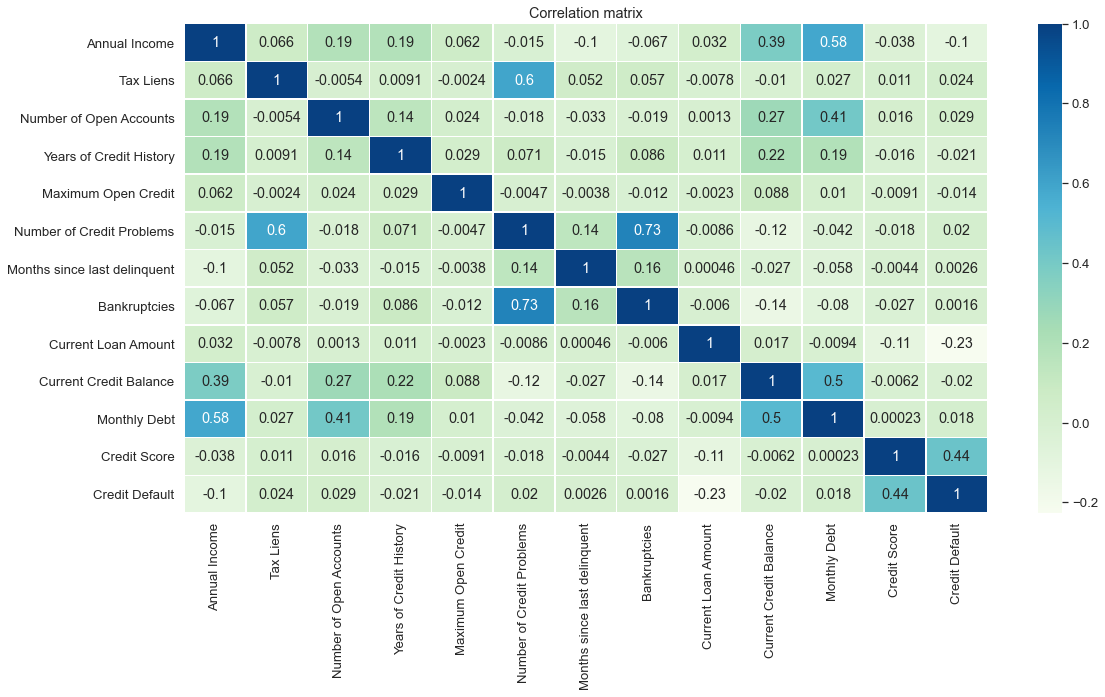

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
# на scaled значения
plt.figure(figsize = (18,9))

sns.set(font_scale=1.2)
sns.heatmap(course_proj_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# посмотреть после перевода категориальных в dummie

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

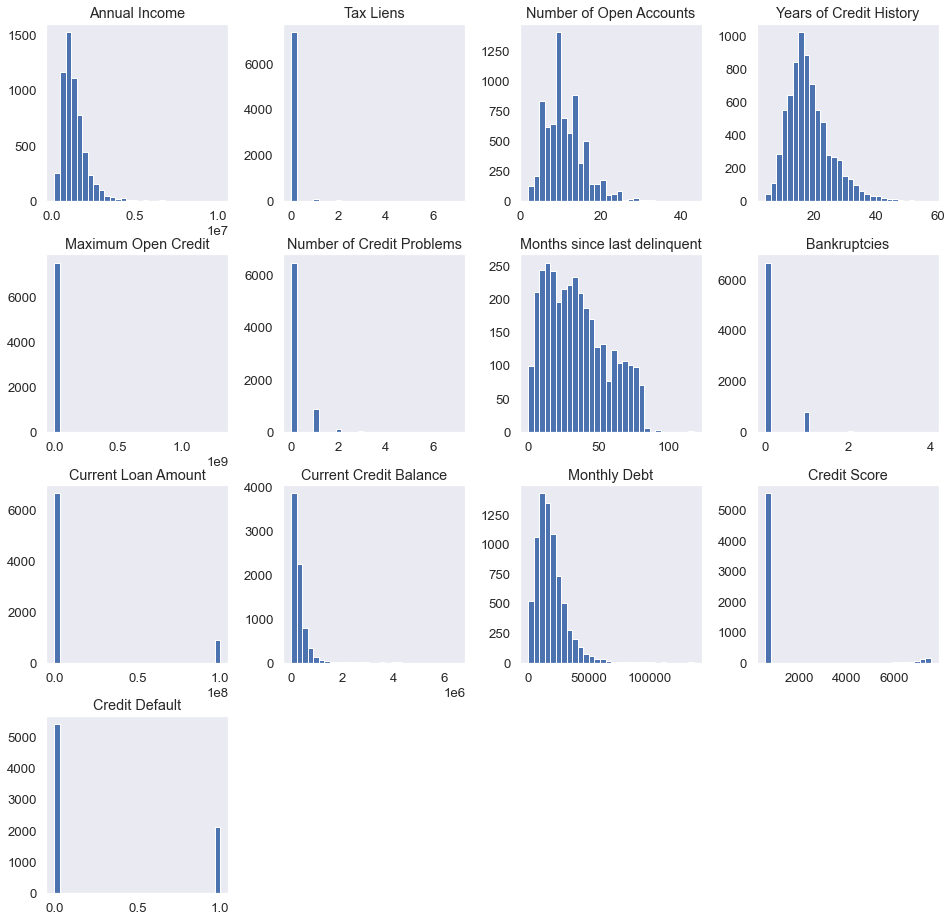

In [12]:
course_proj_train.hist(figsize=(16,16), bins=30, grid=False)

### Заполним пропущенные значения

### Для нейросети заполним

In [13]:
course_proj_train['Credit Score'].mode()[0]

740.0

In [14]:
course_proj_train['Credit Score'].value_counts().head(10)

740.0    169
747.0    168
748.0    157
745.0    152
741.0    151
742.0    151
743.0    148
746.0    145
739.0    144
738.0    137
Name: Credit Score, dtype: int64

In [15]:
course_proj_train.loc[course_proj_train['Credit Score'].isna(), 'Credit Score'] = course_proj_train['Credit Score'].mean()

In [16]:
course_proj_train['Annual Income'].value_counts().head(10)

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
851751.0     3
1160862.0    3
1071125.0    3
939170.0     3
1496288.0    3
Name: Annual Income, dtype: int64

In [17]:
course_proj_train['Annual Income'].mean()

1366391.7201749957

In [18]:
course_proj_train.loc[course_proj_train['Annual Income'].isna(), 'Annual Income'] = course_proj_train['Annual Income'].mean()

In [19]:
course_proj_train['Years in current job'].value_counts().head(10)

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
Name: Years in current job, dtype: int64

In [20]:
course_proj_train.loc[course_proj_train['Years in current job'].isna(), 'Years in current job'] = course_proj_train['Years in current job'].mode()[0]

In [21]:
course_proj_train['Years in current job'].mode()[0]

'10+ years'

In [22]:
course_proj_train = course_proj_train.drop(['Months since last delinquent'], axis=1)

In [23]:
course_proj_train['Bankruptcies'].value_counts().head(10)

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [24]:
course_proj_train.loc[course_proj_train['Bankruptcies'].isna(), 'Bankruptcies'] = course_proj_train['Bankruptcies'].mode()[0]

In [25]:
course_proj_train.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

### Создадим series для целевой переменной в train

In [26]:
train_target = course_proj_train['Credit Default']

<AxesSubplot:>

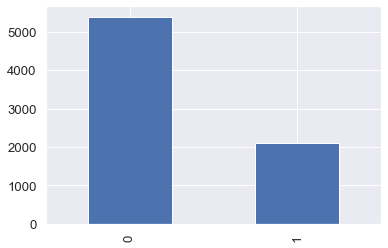

In [27]:
train_target.value_counts().plot.bar()

In [28]:
train_target.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Балансировка классов

In [29]:
course_proj_train.select_dtypes(include='object')

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,10+ years,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term
...,...,...,...,...
7495,Rent,< 1 year,other,Short Term
7496,Home Mortgage,1 year,debt consolidation,Long Term
7497,Rent,6 years,buy a car,Short Term
7498,Home Mortgage,10+ years,debt consolidation,Short Term


In [30]:
course_proj_train.select_dtypes(include=['float64', 'int64'])

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,4.820870e+05,0.0,11.0,26.3,685960.0,1.0,1.0,99999999.0,47386.0,7914.0,749.000000,0
1,1.025487e+06,0.0,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,18373.0,737.000000,1
2,7.514120e+05,0.0,11.0,35.0,1182434.0,0.0,0.0,99999999.0,308389.0,13651.0,742.000000,0
3,8.050680e+05,0.0,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,11338.0,694.000000,0
4,7.762640e+05,0.0,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,7180.0,719.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,4.021920e+05,0.0,3.0,8.5,107866.0,0.0,0.0,129360.0,73492.0,1900.0,697.000000,0
7496,1.533984e+06,0.0,10.0,26.5,686312.0,0.0,0.0,444048.0,456399.0,12783.0,7410.000000,1
7497,1.878910e+06,0.0,12.0,32.1,1778920.0,0.0,0.0,99999999.0,477812.0,12479.0,748.000000,0
7498,1.366392e+06,0.0,21.0,26.5,1141250.0,0.0,0.0,615274.0,476064.0,37118.0,1151.087498,0


In [32]:
disbalance = train_target.value_counts()[0] / train_target.value_counts()[1]
disbalance

2.549455750118315

In [33]:
df_balanced = balance_df_by_target(course_proj_train.select_dtypes(include=['float64', 'int64']), 'Credit Default', method='smote')

df_balanced['Credit Default'].value_counts()

1    5387
0    5387
Name: Credit Default, dtype: int64

In [34]:
df_balanced = pd.concat([df_balanced, course_proj_train.select_dtypes(include='object')], axis=1)

### Удаляем целевую переменную из train датасета

In [37]:
train_target_ = df_balanced['Credit Default']

In [38]:
train_data_ = df_balanced.drop(['Credit Default'], axis=1)

### Посмотрим категориальные признаки, сколько будет дополнительных признаков

In [40]:
train_data_['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [41]:
train_data_['Years in current job'].value_counts() # раннее заполнены Nan

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [42]:
train_data_['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [43]:
train_data_['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

### Сохраним object, уберем из датасета, проведем стандартизацию

In [44]:
train_dummies = train_data_.select_dtypes(include='object')

In [45]:
train_data_ = train_data_.drop(train_data_.select_dtypes(include='object'), axis=1)

In [46]:
train_columns = train_data_.columns
train_columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score'],
      dtype='object')

In [47]:
train_data_ = preprocessing.scale(train_data_)

In [48]:
train_data_ = pd.DataFrame(train_data_, columns=train_columns)

In [49]:
train_data_.head(3)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,-1.198599,-0.122771,-0.037112,1.208775,-0.010902,1.701610,2.630859,3.373936,-0.799242,-0.909409,-0.392532
1,-0.435266,-0.122771,0.811622,-0.427224,0.026165,-0.360847,-0.352110,-0.298179,0.363760,-0.001719,-0.399684
2,-0.820269,-0.122771,-0.037112,2.502702,0.026218,-0.360847,-0.352110,3.373936,0.074058,-0.411520,-0.396704


### Переведем категориальные признаки в dummie

In [50]:
train_dummies = pd.get_dummies(train_dummies)

In [51]:
train_data_ = pd.concat([train_dummies, train_data_], axis=1)

In [52]:
train_data_.shape

(10774, 43)

In [53]:
train_data_.head(3)

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,0,1,0,0,1,0,0,0,0,...,-0.122771,-0.037112,1.208775,-0.010902,1.701610,2.630859,3.373936,-0.799242,-0.909409,-0.392532
1,0,0,1,0,0,1,0,0,0,0,...,-0.122771,0.811622,-0.427224,0.026165,-0.360847,-0.352110,-0.298179,0.363760,-0.001719,-0.399684
2,0,1,0,0,0,0,0,0,0,0,...,-0.122771,-0.037112,2.502702,0.026218,-0.360847,-0.352110,3.373936,0.074058,-0.411520,-0.396704


### Разделим train датасет для обучения и тестирования модели

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_data_, 
    train_target_, 
    test_size=0.3,
    random_state=9)#, 
    #shuffle=True)


# X_train = torch.FloatTensor(X_train)
# X_test = torch.FloatTensor(X_test)
# y_train = torch.LongTensor(y_train)
# y_test = torch.LongTensor(y_test)

In [55]:
X_train.shape

(7541, 43)

In [56]:
X_test.shape

(3233, 43)

In [57]:
X_train.rename(columns={'Years in current job_< 1 year': 'Years in current less_1 year'}, inplace=True)

In [58]:
X_test.rename(columns={'Years in current job_< 1 year': 'Years in current less_1 year'}, inplace=True)

In [59]:
# пропущенные попробовать заполнить моделью, выбросы посмотреть

### XGBoost

In [60]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=3, 
                              )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[12:20:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3772
           1       0.97      0.79      0.87      3769

    accuracy                           0.88      7541
   macro avg       0.90      0.88      0.88      7541
weighted avg       0.90      0.88      0.88      7541

TEST

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1615
           1       0.94      0.74      0.83      1618

    accuracy                           0.85      3233
   macro avg       0.86      0.85      0.85      3233
weighted avg       0.86      0.85      0.85      3233

CONFUSION MATRIX

col_0              0     1
Credit

# II Нейросеть с линейными функциями входа и выхода также с сигмоидными функциями активации

In [53]:
# class WineNet(torch.nn.Module):
#     def __init__(self, n_hidden_neurons):
#         super(WineNet, self).__init__()
        
#         self.fc1 = torch.nn.Linear(43, n_hidden_neurons)
#         self.activ1 = torch.nn.Sigmoid()
#         self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
#         self.activ2 = torch.nn.Sigmoid()
#         self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
#         self.sm = torch.nn.Softmax(dim=1)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.activ1(x)
#         x = self.fc2(x)
#         x = self.activ2(x)
#         x = self.fc3(x)
#         return x

#     def inference(self, x):
#         x = self.forward(x)
#         x = self.sm(x)
#         return x
    
# wine_net = WineNet(20)

In [54]:
# loss = torch.nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(wine_net.parameters(), 
#                              lr=1.0e-3)

In [55]:
# batch_size = 50

# for epoch in range(5000):
#     order = np.random.permutation(len(X_train))
#     for start_index in range(0, len(X_train), batch_size):
#         optimizer.zero_grad()
        
#         batch_indexes = order[start_index:start_index+batch_size]
#         #print(batch_indexes)
        
#         x_batch = X_train[batch_indexes]
#         #print(x_batch.shape)
#         y_batch = y_train[batch_indexes]
#         #print(y_batch.shape)
#         preds = wine_net.forward(x_batch) 
        
#         loss_value = loss(preds, y_batch)
#         loss_value.backward()
        
#         optimizer.step()
        
#     if epoch % 100 == 0:
#         test_preds = wine_net.forward(X_test)
#         test_preds = test_preds.argmax(dim=1)
#         preds1 = (test_preds == y_test).float().mean()
#         print(preds1)
#         if preds1 > 0.96:
#             break

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1



xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))
#print(torch.meshgrid(torch.arange(x_min, x_max, plot_step)))
print(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1).shape)

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------